In [3]:
import pickle
import random
import sys
import io
import os
import re
import keras
import urllib
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.text import one_hot
from skimage.color import rgb2grey
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.datasets import cifar10

import warnings
warnings.filterwarnings("ignore")

# Extract the class birds data.

Number of Training Instances: 5000
Number of Testing Instances: 1000
First 10 Images in the dataset:


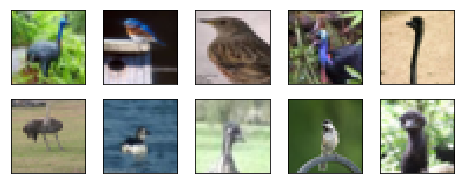

In [4]:
(trainFeatures, trainLabels), (testFeatures, testLabels) = cifar10.load_data()
numTrain, imgRows, imgCols, imgChannels = trainFeatures.shape
numTest, _, _, _ = testFeatures.shape
numClasses = len(np.unique(trainLabels))

trainBirdIndex = np.where(trainLabels[:]==2)[0]
trainBirdFeatures = trainFeatures[trainBirdIndex,::]
trainBirdLabels = trainLabels[trainBirdIndex,::]
print('Number of Training Instances:', trainBirdFeatures.shape[0])

testBirdIndex = (np.where(testLabels[:]==2)[0])
testBirdFeatures = testFeatures[testBirdIndex,::]
testBirdLabels = testLabels[testBirdIndex,::]
print('Number of Testing Instances:', testBirdFeatures.shape[0])

cifarDataX = np.concatenate((trainBirdFeatures, testBirdFeatures), axis=0)
cifarDataY = np.concatenate((trainBirdLabels, testBirdLabels),axis=0)

print('First 10 Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(cifarDataX[i])
plt.show()

# Choose pixels in the image.

In [5]:
totalPixels = cifarDataX.shape[0] * cifarDataX.shape[1] * cifarDataX.shape[2]
cifarDataFlatX = cifarDataX.reshape(totalPixels, imgChannels)
print('Total Pixels:', cifarDataFlatX.shape)

Total Pixels: (6144000, 3)


# K-Means Clustering to find 24 main colors.

In [59]:
colors = 24
kMeansModel = KMeans(n_clusters=colors)
kMeansModel = kMeansModel.fit(cifarDataFlatX)
mainColors = kMeansModel.cluster_centers_
print('RGB of', colors, 'Main Colors:')
print(mainColors)

RGB of 24 Main Colors:
[[161.544502   146.52208676 111.85325256]
 [ 59.78397318  61.50789947  47.12588682]
 [176.01338814 206.0704404  233.75841848]
 [ 74.72883284  80.49627367  75.19386558]
 [183.05888955 184.64124661 182.01469458]
 [244.71902939 245.83936189 244.25030678]
 [104.31644257  97.65699979  79.29271095]
 [131.32302539 134.83353574 130.22221445]
 [215.60911488 198.83962961 157.67544981]
 [103.90423695 126.22587255  55.69812562]
 [ 39.68532567  40.42646246  31.48513768]
 [218.10327687 216.2970806  209.61521406]
 [132.78665258 122.41602797  93.99486163]
 [ 47.4408581   92.34932428 141.44536837]
 [103.96739302 111.48219576 110.40957318]
 [ 89.75845448 135.36428845 185.57186305]
 [ 90.8554814   81.49280458  44.94491316]
 [137.56639359 158.1366112   80.20464972]
 [130.90119365 170.82586626 214.26436435]
 [198.41474696 169.26339235  79.93478707]
 [148.13346642 105.03955201  59.91204578]
 [ 15.41973996  16.08028262  13.22647048]
 [155.0766876  158.0626249  154.97258514]
 [183.43785

In [60]:
predClusterLabels = kMeansModel.predict(cifarDataFlatX)
newCifarDataX = []
pixelMainColors = []
i = 0
while i<len(predClusterLabels):
    clusterLabel = predClusterLabels[i]
    newCifarDataX.append(mainColors[clusterLabel])
    oneHotEncoding = np.zeros(colors)
    oneHotEncoding[clusterLabel] = 1
    pixelMainColors.append(oneHotEncoding)
    i += 1
newCifarDataX = np.array(newCifarDataX)
newCifarDataX = np.reshape(newCifarDataX, (cifarDataX.shape[0], imgRows, imgCols, imgChannels)) 

pixelMainColors = np.array(pixelMainColors)
pixelMainColors = np.reshape(pixelMainColors, (cifarDataX.shape[0], imgRows*imgCols*colors))

Some 24 Colored Images in the dataset:


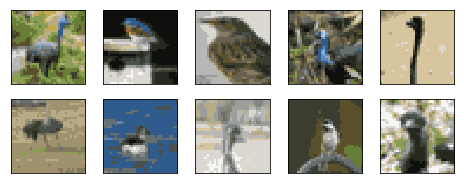

In [61]:
print('Some', colors,'Colored Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(newCifarDataX[i].astype(np.uint8))
plt.show()

# Obtain grayscale 32x32x1 images from the original 32x32x3 images.

In [62]:
greyTrainBirdFeatures = []
for i in range(trainBirdFeatures.shape[0]):
    greyTrainBirdFeatures.append(rgb2grey(trainBirdFeatures[i]))
greyTrainBirdFeatures = np.asarray(greyTrainBirdFeatures)

greyTestBirdFeatures = []
for i in range(testBirdFeatures.shape[0]):
    greyTestBirdFeatures.append(rgb2grey(testBirdFeatures[i]))
greyTestBirdFeatures = np.asarray(greyTestBirdFeatures)

First 10 Greyscale Training Images in the dataset:


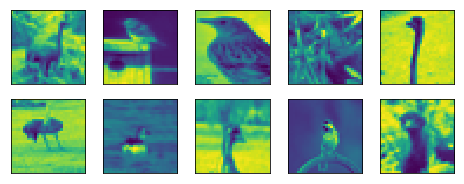

In [63]:
print('First 10 Greyscale Training Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(greyTrainBirdFeatures[i])
plt.show()

First 10 Greyscale Testing Images in the dataset:


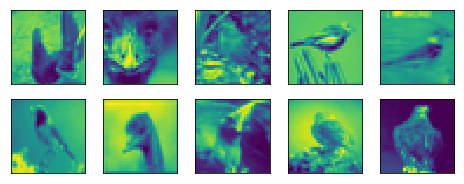

In [64]:
print('First 10 Greyscale Testing Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(greyTestBirdFeatures[i])
plt.show()

# Deep Convolutional Neural Network.

In [65]:
modelCNN = Sequential()
modelCNN.add(Conv2D(128, 
                    kernel_size=(5, 5), 
                    strides=1, 
                    input_shape=(32, 32, 1),
                    padding='same',
                    activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2),
                          padding='same'))

modelCNN.add(Conv2D(128, 
                    kernel_size=(5, 5),
                    strides=1, 
                    padding='same',
                    activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2),
                          padding='same'))

modelCNN.add(Flatten())

modelCNN.add(Dense(2048, 
                   activation = 'relu'))

modelCNN.add(Dense(1024*colors, 
                   activation = 'softmax'))

modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 128)       3328      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dense_9 (Dense)              (None, 24576)             50356224  
Total para

In [66]:
adamOptimizer = keras.optimizers.Adam(lr=0.001)
modelCNN.compile(optimizer=adamOptimizer, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [67]:
cnnModelFolder = str(colors) + ' Colors Model/'
cnnFileName = cnnModelFolder + "cnnmodel-{epoch:02d}-{loss:.4f}.hdf5"
cnnCheckpoint = ModelCheckpoint(cnnFileName, 
                                verbose = 1, 
                                save_best_only = False, 
                                save_weights_only = False, 
                                period = 1)

In [68]:
greyTrainBirdFeatures = np.reshape(greyTrainBirdFeatures, (len(greyTrainBirdFeatures), imgRows, imgCols, 1))
greyTestBirdFeatures = np.reshape(greyTestBirdFeatures, (len(greyTestBirdFeatures), imgRows, imgCols, 1))

In [76]:
epoch = 50
history = modelCNN.fit(greyTrainBirdFeatures, 
                       pixelMainColors[:greyTrainBirdFeatures.shape[0]],
                       epochs=epoch, 
                       shuffle=True,
                       verbose=1,
                       validation_split=0.1,
                       callbacks=[cnnCheckpoint])

Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 218s 48ms/step - loss: 7974.9900 - acc: 8.8889e-04 - val_loss: 10843.8461 - val_acc: 0.0000e+00

Epoch 00001: saving model to 24 Colors Model/cnnmodel-01-7974.9900.hdf5
Epoch 2/50
4500/4500 [==============================] - 195s 43ms/step - loss: 7963.5098 - acc: 8.8889e-04 - val_loss: 10883.3120 - val_acc: 0.0000e+00

Epoch 00002: saving model to 24 Colors Model/cnnmodel-02-7963.5098.hdf5
Epoch 3/50
4500/4500 [==============================] - 186s 41ms/step - loss: 7951.9259 - acc: 0.0013 - val_loss: 10904.3985 - val_acc: 0.0000e+00

Epoch 00003: saving model to 24 Colors Model/cnnmodel-03-7951.9259.hdf5
Epoch 4/50
4500/4500 [==============================] - 180s 40ms/step - loss: 7945.2843 - acc: 0.0020 - val_loss: 10940.6474 - val_acc: 0.0000e+00

Epoch 00004: saving model to 24 Colors Model/cnnmodel-04-7945.2843.hdf5
Epoch 5/50
4500/4500 [==============================] - 176s 


Epoch 00037: saving model to 24 Colors Model/cnnmodel-37-7757.3975.hdf5
Epoch 38/50
4500/4500 [==============================] - 193s 43ms/step - loss: 7751.6259 - acc: 0.0011 - val_loss: 11684.4397 - val_acc: 0.0000e+00

Epoch 00038: saving model to 24 Colors Model/cnnmodel-38-7751.6259.hdf5
Epoch 39/50
4500/4500 [==============================] - 195s 43ms/step - loss: 7746.4195 - acc: 0.0013 - val_loss: 11650.3389 - val_acc: 0.0000e+00

Epoch 00039: saving model to 24 Colors Model/cnnmodel-39-7746.4195.hdf5
Epoch 40/50
4500/4500 [==============================] - 199s 44ms/step - loss: 7744.1959 - acc: 0.0011 - val_loss: 11653.8298 - val_acc: 0.0000e+00

Epoch 00040: saving model to 24 Colors Model/cnnmodel-40-7744.1959.hdf5
Epoch 41/50
4500/4500 [==============================] - 191s 43ms/step - loss: 7738.1543 - acc: 0.0016 - val_loss: 11698.6425 - val_acc: 0.0000e+00

Epoch 00041: saving model to 24 Colors Model/cnnmodel-41-7738.1543.hdf5
Epoch 42/50
4500/4500 [================

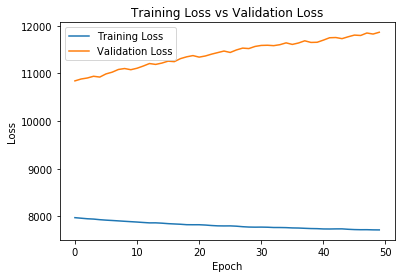

In [77]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [78]:
modelFiles = os.listdir(cnnModelFolder)
finalCNNModelFile = '' 
minCNNLoss = None
for modelFile in modelFiles:
    if modelFile.startswith('cnnmodel'):
        idx = modelFile.rindex('-')
        modelLoss = modelFile[idx+1:len(modelFile)-5]
        if minCNNLoss==None or modelLoss<minCNNLoss:
            minCNNLoss = modelLoss
            finalCNNModelFile = modelFile
print('Best CNN Model with Less Loss:', finalCNNModelFile)

Best CNN Model with Less Loss: cnnmodel-50-7717.8721.hdf5


In [79]:
bestCNNModel = keras.models.load_model(cnnModelFolder + finalCNNModelFile)

In [80]:
predictedCNNTest = bestCNNModel.predict(greyTestBirdFeatures[:10])

In [81]:
predictedTestImages = np.reshape(predictedCNNTest,(10240, colors))
outputImages = []
for pixel in predictedTestImages:
    outputImages.append(mainColors[np.argmax(pixel)])
outputImages = np.reshape(outputImages,(10,32,32,3))

  Original Image        CNN Colored Image       Greyscale Image


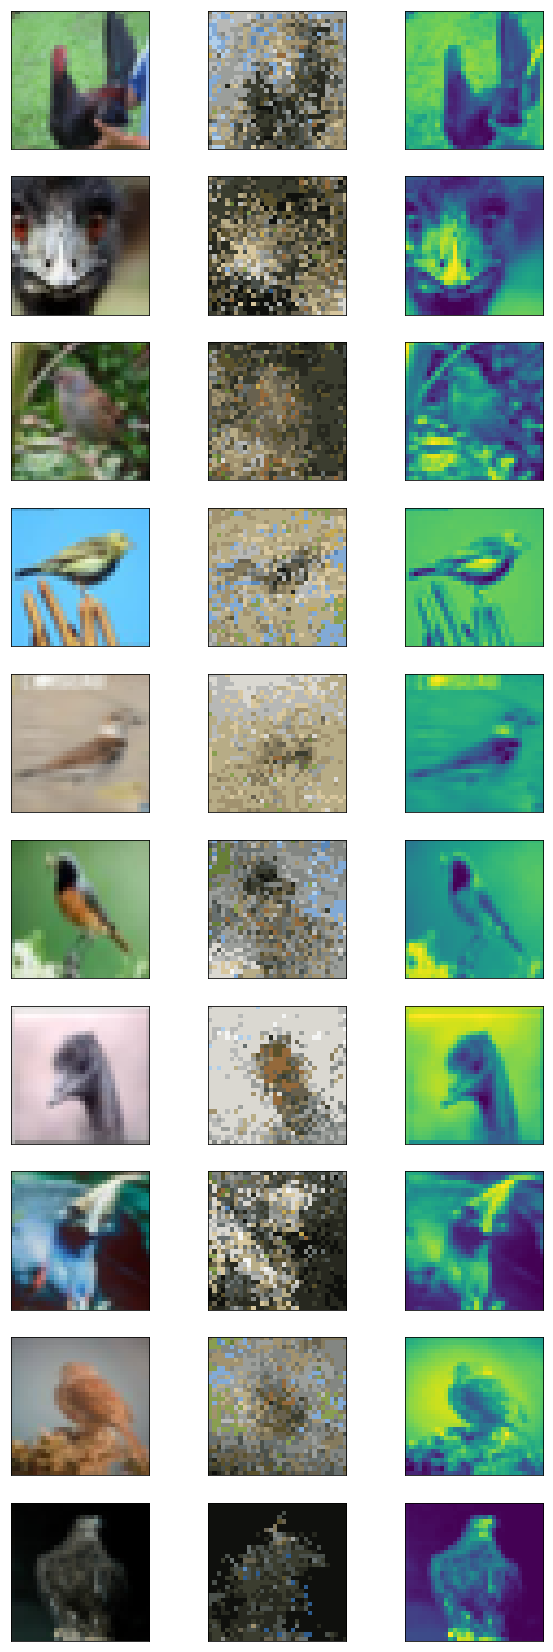

In [90]:
print('  Original Image        CNN Colored Image       Greyscale Image')
fig = plt.figure(figsize=(10, 30))
for i in range(0, 30):
    ax = fig.add_subplot(10, 3, i+1, xticks=[], yticks=[])
    if i%3==0:
        plt.imshow(testBirdFeatures[int(i/3)])
    elif i%3==1:
        plt.imshow(outputImages[int((i-1)/3)].astype(np.uint8))
    else:
        plt.imshow(greyTestBirdFeatures[int((i-2)/3)].reshape(32, 32))
plt.show()